In [1]:
# -*-coding:utf-8 -*-
# import all the libraries 
# python==3.8; jupyterlab==3.0.12; lumicks.pylake==0.8.1; matplotlib==3.3.4; more-itertools==8.7.0;
# npTDMS==1.1.0; numpy==1.20.1; opencv-python==4.5.1.48; pandas==1.2.3; scipy==1.6.1; tifffile==2021.3.5
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import scipy.optimize
%matplotlib widget

# Plot reference 
1. Setting a relative frequency in a matplotlib histogram [https://stackoverflow.com/questions/9767241/setting-a-relative-frequency-in-a-matplotlib-histogram]
2. Bin size in Matplotlib (Histogram) [https://stackoverflow.com/questions/6986986/bin-size-in-matplotlib-histogram]
3. logscale axis [https://stackoverflow.com/questions/773814/plot-logarithmic-axes-with-matplotlib-in-python]
4. binwidth for histogram Using the The Freedman-Diaconis Rules to calculate the binwidth: The bin-width is set to h=2×IQR×n^(−1/3),the number of bins is (max−min)/h; where IQR is the interquartile range of the data and n is the number of observations in the sample [https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram]
5. Alternatively, The simplest method is to set the number of bins equal to the square root of the number of values you are binning.
6. Generate random numbers from exponential distribution [https://stackoverflow.com/questions/47319277/generate-random-numbers-from-exponential-distribution-and-model-using-python]
7. error band plot [https://stackoverflow.com/questions/55368485/draw-error-shading-bands-on-line-plot-python?noredirect=1&lq=1]

In [2]:
# read and plot the trajectory analysis data from Kymotracker
# trace_name = input('please type in the file name:' ) + '.xlsx'
# trace_path = input('please type in the file path:')
# trace_file = os.path.join(trace_path, trace_name) 
trace_file = input('please type in the file path:')

please type in the file path: /Users/longfu/Desktop/Bleaching test/bleaching_time_June9.xlsx


In [38]:
trace = pd.read_excel(trace_file,sheet_name='summary')
print(trace.head())
duration = trace['BleTime_Alexa']/1000
data = duration.dropna()
print(data)
print(np.average(data))

   BleTime_Alexa  BleTime_Atto  Unnamed: 2  Unnamed: 3     dt_ms
0         296063           NaN         NaN         NaN   76700.0
1          78119           NaN         NaN         NaN   22010.0
2          64628           NaN         NaN         NaN  120742.0
3          54681           NaN         NaN         NaN   18455.0
4          11361           NaN         NaN         NaN    3547.0
0       296.063
1        78.119
2        64.628
3        54.681
4        11.361
         ...   
3142      2.842
3143      6.389
3144      2.136
3145      2.846
3146      3.550
Name: BleTime_Alexa, Length: 3147, dtype: float64
9.542680330473466


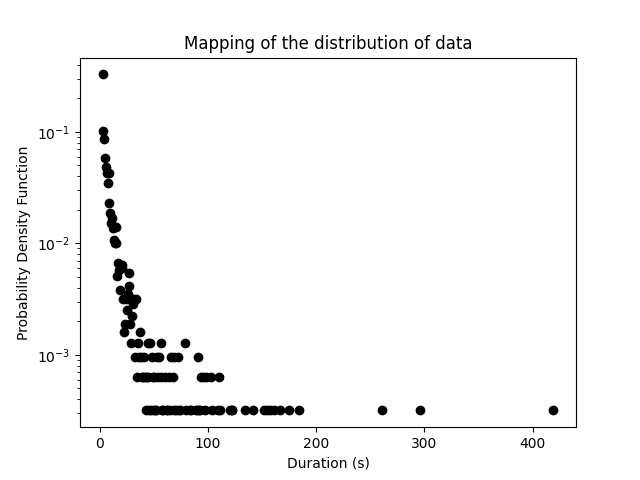

In [39]:
#calculate interquartile range and subsequent binwidth, and then histogram
# q3, q1 = np.percentile(data, [75 ,25])
# iqr = q3 - q1
# binwidth = (2* iqr) * len(data) ** (-1/3)
# print(binwidth)
binwidth = 0.8

ydata,base = np.histogram(data,bins = np.arange(min(data), max(data)+ binwidth, binwidth), weights=np.zeros_like(data) + 1. / data.size)
xdata = base[:-1] + 0.5*binwidth

plt.figure()
plt.scatter(xdata, ydata, color="k")
plt.yscale('log')
# plt.ylim(0.001,1)
# plt.xlim(0,8)
plt.ylabel('Probability Density Function')
plt.xlabel('Duration (s)')
plt.title('Mapping of the distribution of data')
plt.show()
# plt.savefig(trace_file[:-18]+ 'Mapping of the distribution of data' +'.png', dpi=300)
# plt.savefig(trace_file[:-5]+ '_Mapping of the distribution of data' +'.png', dpi=300)

In [40]:
# this step is to fit the data in a specific range
xdata1 = xdata[np.where(xdata<70)]
ydata1 = ydata[np.where(xdata<70)]

[0.36875005 0.05442173]
[2.3559476  0.81162311]
R² = 0.9181375999482168


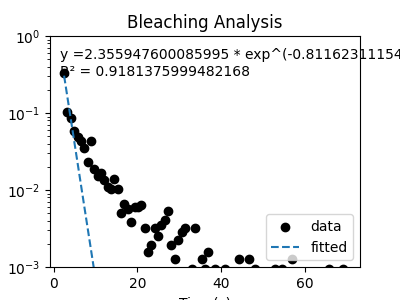

In [41]:
# fit the data with a monoExponential decay curve
def monoExp(x, a, k):
    return a * np.exp(-k * x) 

# perform the fit
popt, pcov = scipy.optimize.curve_fit(monoExp, xdata1, ydata1)
# a is the initial value A1, k is the decay constant
a, k = popt
perr = np.sqrt(np.diag(pcov))
print(perr)
print(popt)

# determine quality of the fit
squaredDiffs = np.square(ydata1 - monoExp(xdata1, a, k))
squaredDiffsFromMean = np.square(ydata1 - np.mean(ydata1))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")


# plot the results
plt.figure(figsize = (4,3))
plt.scatter(xdata1, ydata1, color="k", label="data")
plt.plot(xdata1, monoExp(xdata1, a, k), '--', label="fitted")
# plt.plot(xdata2, monoExp(xdata2, a, k)/a, 'yellow', label="normarlized")

plt.text(1.5,0.5,'y =' + str(a) + ' * exp^('+ str(-k)+'x)')
plt.text(1.5,0.3,'R² = ' + str(rSquared))
plt.yscale('log')
plt.ylim(0.001,1)
# plt.xlim(0,8)
plt.legend(loc = 'lower right')
plt.ylabel('Probability Density Function')
plt.xlabel('Time(s)')
plt.title("Bleaching Analysis")
plt.show()
# plt.savefig("figures/Fig 3F" +'.eps', format='eps')

# Form now on, we start to bootstrap the data

In [7]:
# random sampling
resampling_ratio = 0.8
resampling_times = 10000

# define a monoExponential decay fit function
def monoExp(x, a, k):
    return a * np.exp(-k * x) 

# define a function to compute the decay constant from an exponential decay fit, with return of decay constant
def ExoDecFit (data):
    #calculate interquartile range and subsequent binwidth, and then histogram
    # q3, q1 = np.percentile(data, [75 ,25])
    # iqr = q3 - q1
    # binwidth = (2* iqr) * len(data) ** (-1/3)
    binwidth = 0.4
    ydata,base = np.histogram(data,bins = np.arange(min(data), max(data)+ binwidth, binwidth), weights=np.zeros_like(data) + 1. / data.size)
    xdata = base[:-1] + 0.5*binwidth
    xdata1 = xdata[np.where(xdata<8)]
    ydata1 = ydata[np.where(xdata<8)]

    # perform the fit
    try:
        popt, pcov = scipy.optimize.curve_fit(monoExp, xdata1, ydata1)
    except RuntimeError:
        pass
    # a is the initial value A1, k is the decay constant
    a, k = popt
    return k

decay_constant_ls = []
for i in range (resampling_times):
    # random sampling with replacement method,
    data_resampling = np.random.choice(data, size= int(resampling_ratio * len(data)), replace=True)
    decay_constant = ExoDecFit(data_resampling)
    decay_constant_ls.append(decay_constant)

        # return format(np.mean(decay_constant_ls),'.4f'),format (np.std(decay_constant_ls),'.4f')
    
print(len(decay_constant_ls))
print(np.mean(decay_constant_ls))
print(np.std(decay_constant_ls))

10000
8.600609026637155
0.3589096665748258


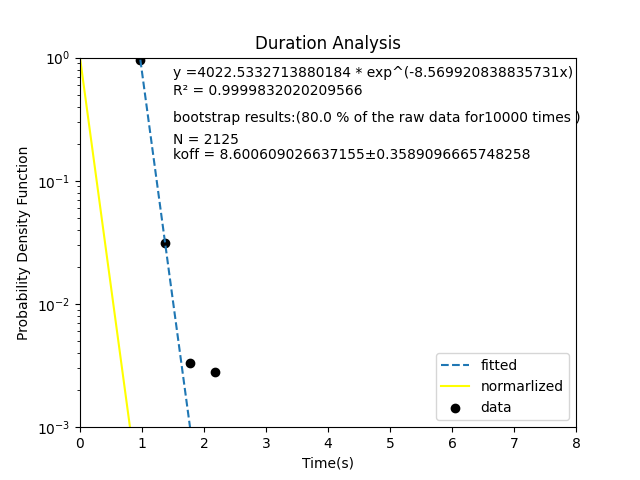

In [8]:
# plot the results
plt.figure()
plt.scatter(xdata1, ydata1, color="k", label="data")
plt.plot(xdata1, monoExp(xdata1, a, k), '--', label="fitted")
plt.plot(xdata2, monoExp(xdata2, a, k)/a, 'yellow', label="normarlized")

plt.text(1.5,0.7,'y =' + str(a) + ' * exp^('+ str(-k)+'x)')
plt.text(1.5,0.5,'R² = ' + str(rSquared))
plt.text(1.5,0.3,'bootstrap results:'+ '('+ str(resampling_ratio*100) + ' % of the raw data ' + 'for' + str(resampling_times) + ' times )')
plt.text(1.5,0.2,'N = ' + str(len(data)))
plt.text(1.5,0.15,'koff = ' + str(np.mean(decay_constant_ls)) + '±' +  str(np.std(decay_constant_ls)))

plt.yscale('log')
plt.ylim(0.001,1)
plt.xlim(0,8)
plt.legend(loc = 'lower right')
plt.ylabel('Probability Density Function')
plt.xlabel('Time(s)')
plt.title("Duration Analysis")
plt.show()
# plt.savefig(trace_file[:-18]+ 'duration-analysis' +'.png', dpi=300)
# plt.savefig(trace_file[:-5]+ '_duration-analysis' +'.png', dpi=300)

In [9]:
pause
# we will not use the following codes

NameError: name 'pause' is not defined

In [ ]:
duration = mydata
time_bin = xdata2
frequency_fit = monoExp(xdata2, a, k)
frequency_fit_norm = monoExp(xdata2, a, k)/a
fit_data =  np.vstack((time_bin,frequency_fit,frequency_fit_norm)).T
exp_output = np.array([duration,fit_data],dtype=object)
print(exp_output)
np.save(trace_file[:-4]+ '_duration-analysis' + '.npy', exp_output, allow_pickle=True)

In [ ]:
pause
exp_output = np.load(trace_file[:-4]+ '_duration-analysis' + '.npy', allow_pickle=True)
frequency_fit_norm = exp_output[1][:,2]

In [ ]:
# read and plot the trajectory analysis data from Kymotracker
name = input('please type in the file name:' ) 
path = input('please type in the file path:')
file = os.path.join(path, name) 
exp_output_2 = np.load(file, allow_pickle=True)

In [ ]:
time = np.arange(0,15,0.5)
frequency_fit_norm_1 = exp_output_1[1][:,2]
frequency_fit_norm_2 = exp_output_2[1][:,2]
# frequency_fit_norm_3 = exp_output_3[1][:,2]
# frequency_fit_norm_4 = exp_output_4[1][:,2]
# frequency_fit_norm_5 = exp_output_5[1][:,2]
# frequency_fit_norm_6 = exp_output_6[1][:,2]
# frequency_fit_norm_7 = exp_output_7[1][:,2]


plt.figure()
plt.scatter(time,frequency_fit_norm_1,color = 'r')
plt.plot(time,frequency_fit_norm_1,'--')
plt.scatter(time,frequency_fit_norm_2,color = 'blue')
plt.plot(time,frequency_fit_norm_2,'--')
# plt.scatter(time,frequency_fit_norm_3,color = 'green')
# plt.plot(time,frequency_fit_norm_3,'--')
# plt.scatter(time,frequency_fit_norm_4,color = 'green')
# plt.plot(time,frequency_fit_norm_4,'--')
# plt.scatter(time,frequency_fit_norm_5,color = 'green')
# plt.plot(time,frequency_fit_norm_5,'--')
# plt.scatter(time,frequency_fit_norm_6,color = 'green')
# plt.plot(time,frequency_fit_norm_6,'--')
# plt.scatter(time,frequency_fit_norm_7,color = 'green')
# plt.plot(time,frequency_fit_norm_7,'--')
# plt.plot(time,(frequency_fit_norm_1+frequency_fit_norm_2+frequency_fit_norm_3+frequency_fit_norm_4+frequency_fit_norm_5+frequency_fit_norm_6+frequency_fit_norm_7)/7,linewidth = 3,color = "black",label ="average")

plt.xlabel('Time(s)')
plt.ylabel("Frequency")
plt.yscale('log')
plt.ylim(0.01,1)
plt.xlim(0,15)
plt.title("Duration Analysis")
plt.legend()

plt.show()
# fig.savefig('_duration-analysis' +'.png', dpi=150)